# Kriptonite

### Draft Kripton analysis

In [1]:
import time

In [2]:
from __future__ import print_function

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

In [7]:
import Core.system_of_units as units
import tables
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm

In [8]:
from Database import loadDB

In [9]:
import ICython.Sierpe.cBLR as cblr

In [10]:
from scipy import signal

In [11]:
%load_ext Cython

In [12]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

07/12/2016
16:22:52


### Deconvolution 

In [29]:
%%cython
import numpy as np
cimport numpy as np
from scipy import signal as SGN

cpdef deconvolve_signal(double [:] signal_daq,
                        int n_baseline=28000,
                        double coef_clean=2.905447E-06,
                        double coef_blr=1.632411E-03,
                        double thr_trigger=5,
                        int acum_discharge_length = 5000):

    """
    The accumulator approach by Master VHB
    decorated and cythonized  by JJGC
    22.11 Compute baseline using all the waveforms
          computes accumulator threshold from thr_trigger
          simplify discharge wrt previous versions:
    In this verison the recovered signal and the accumulator are
    always being charged. At the same time, the accumulator is being
    discharged when there is no signal. This avoids runoffs
    The baseline is computed using a window of 700 mus (by default)
    which should be good for Na and Kr
    """

    cdef double coef = coef_blr
    cdef int nm = n_baseline
    cdef double thr_acum = thr_trigger/coef
    cdef int len_signal_daq = len(signal_daq)

    cdef double [:] signal_r = np.zeros(len_signal_daq, dtype=np.double)
    cdef double [:] acum = np.zeros(len_signal_daq, dtype=np.double)
    #cdef double [:] signal_daq = signal_i.astype(np.double)

    # compute baseline and noise

    cdef int j
    cdef double baseline = 0.
    cdef double baseline_end = 0.

    for j in range(0,nm):
        baseline += signal_daq[j]
    baseline /= nm

    # reverse sign of signal and subtract baseline
    for j in range(0,len_signal_daq):
        signal_daq[j] = baseline - signal_daq[j]
    
    # compute noise
    cdef double noise =  0.
    cdef int nn = 400 # fixed at 10 mus
    
    for j in range(0,nn):
        noise += signal_daq[j] * signal_daq[j]
    noise /= nn
    cdef double noise_rms = np.sqrt(noise)

    # trigger line
    cdef double trigger_line = thr_trigger * noise_rms

    # cleaning signal
    cdef double [:]  b_cf
    cdef double [:]  a_cf

    b_cf, a_cf = SGN.butter(1, coef_clean, 'high', analog=False);
    signal_daq = SGN.lfilter(b_cf,a_cf,signal_daq)

    cdef int k
    j=0
    signal_r[0] = signal_daq[0]
    for k in range(1,len_signal_daq):

        # always update signal and accumulator
        signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) +\
                      coef * acum[k-1]

        acum[k] = acum[k-1] + signal_daq[k]

        if (signal_daq[k] < trigger_line) and (acum[k-1] < thr_acum):
            # discharge accumulator

            if acum[k-1]>1:
                acum[k] = acum[k-1] * (1. - coef)
                if j < acum_discharge_length - 1:
                    j = j + 1
                else:
                    j = acum_discharge_length - 1
            else:
                acum[k]=0
                j=0
    # return recovered signal 
    return signal_r


cpdef deconv_pmt(np.ndarray[np.int16_t, ndim=2] pmtrwf, double [:] coeff_c, double [:] coeff_blr, 
                 int n_baseline=28000, double thr_trigger=5):
    """
    Deconvolution of all the PMTs in the event cython function
    """
    
    cdef int NPMT = pmtrwf.shape[0]
    cdef int NWF = pmtrwf.shape[1]
    cdef double [:, :] signal_i = pmtrwf.astype(np.double)
    cdef double [:] signal_r = np.zeros(NWF, dtype=np.double)
    CWF = []
    
    cdef int pmt
    for pmt in range(NPMT):
       
        signal_r = deconvolve_signal(signal_i[pmt],
                                     n_baseline=n_baseline,
                                     coef_clean=coeff_c[pmt],
                                     coef_blr=coeff_blr[pmt],
                                     thr_trigger=thr_trigger)
                             
        CWF.append(signal_r)
            
        
    return np.array(CWF)

In [16]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976/'
ffile = 'run_2976.gdc1next.000.next1el_2976.root.h5'
r2976 = tables.open_file(path+ffile,'r+')
pmtrwf = r2976.root.RD.pmtrwf

In [17]:
DataPMT = loadDB.DataPMT(2976)
adc_to_pes = abs(DataPMT.adc_to_pes.values).astype(np.double)
coeff_c = abs(DataPMT.coeff_c.values).astype(np.double)
coeff_blr = abs(DataPMT.coeff_blr.values).astype(np.double)

In [30]:
event = 0

In [31]:
CWF = deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)

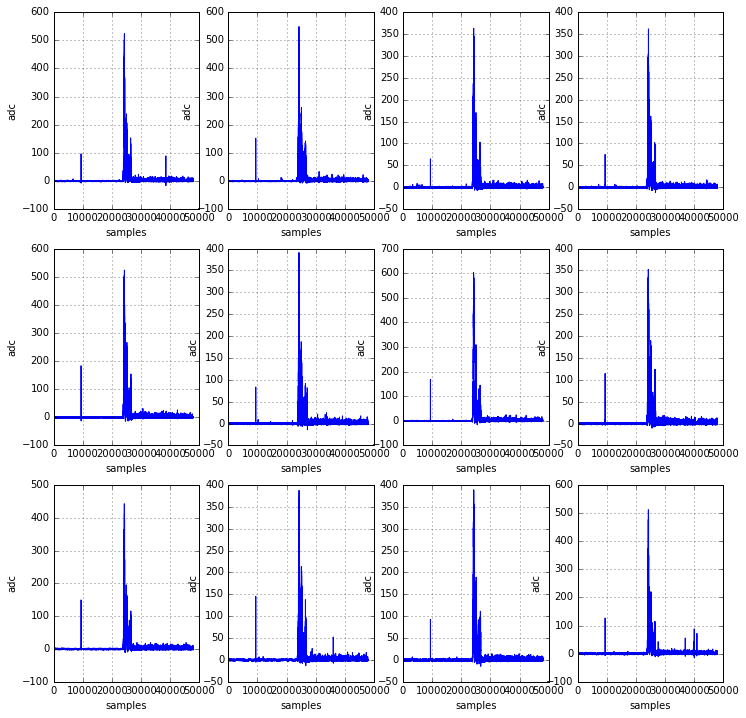

In [32]:
mpl.plot_waveforms(CWF)

### Calibrated PMT sum

In [34]:
%%cython
cimport numpy as np
import numpy as np
from scipy import signal

cpdef calibrated_pmt_sum(double [:, :] CWF,  
                         double [:] adc_to_pes, 
                         int n_MAU=200,
                         double thr_MAU=5):
    """
    kriptonize computes the ZS calibrated sum of the PMTs after correcting the baseline
    with a MAU to suppress low frequency noise.
    
    """
    
    cdef int j, k
    cdef int NPMT = CWF.shape[0]
    cdef int NWF = CWF.shape[1]
    cdef double [:] MAU = np.array(np.ones(n_MAU),dtype=np.double)*(1./float(n_MAU))
      
   
    # CWF if above MAU threshold
    cdef double [:, :] pmt_thr = np.zeros((NPMT,NWF), dtype=np.double)
    cdef double [:] csum = np.zeros(NWF, dtype=np.double)
    cdef double [:] MAU_pmt = np.zeros(NWF, dtype=np.double)
    
    for j in range(NPMT):
        # MAU for each of the PMTs, following the waveform   
        MAU_pmt = signal.lfilter(MAU,1,CWF[j,:])
        
        for k in range(NWF):
            if CWF[j,k] > MAU_pmt[k] + thr_MAU:
                pmt_thr[j,k] = CWF[j,k]
   
    for j in range(NPMT):
        for k in range(NWF):
            csum[k] += CWF[j, k]*1./adc_to_pes[j]
    return csum

In [35]:
csum = calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 

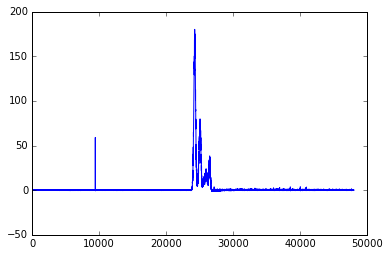

In [36]:
plt.plot(csum)

In [62]:
r2976.close()

### Plotting functions

In [13]:
def SetPlotLabels(xlabel="", ylabel="", grid=True):
    """
    Short cut to set labels in plots
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if grid is True:
        plt.grid(which="both", axis="both")


In [14]:
def plot_signal(signal_t, signal, title="signal",
                signal_start=0, signal_end=1e+4, ymax = 200, units=""):
    """
    Given a series signal (t, signal), plot the signal
    """

    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlim([signal_start, signal_end])
    ax1.set_ylim([0, ymax])
    SetPlotLabels(xlabel="t (ns)", ylabel="signal (%s)" % units)
    plt.title(title)
    plt.plot(signal_t, signal)
    plt.show()

### Peak finding, rebinning and ZS functions

In [37]:
def wfdf(time, energy_pes):
    """
    input: time, energy vectors: 
    returns a data frame representing a waveform
    """
    swf = {}
    swf['time_ns'] = time
    swf['ene_pes'] = energy_pes 
    return pd.DataFrame(swf)

In [38]:
def wf_thr(wf,threshold=0):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]

In [39]:
def find_S12(wfzs, tmin=0*units.mus, tmax=1200*units.mus, stride=4, lmin=8, lmax=1e+6):
    """
    Find S1/S2 peaks.
    input: a zero supressed wf
    returns a list of waveform data frames
    do not interrupt the peak if next sample comes within stride
    accept the peak only if within [lmin, lmax)
    accept the peak only if within [tmin, tmax)
    """
    
    T = wfzs['time_ns'].values
    P = wfzs['ene_pes'].values
    
    S12 = {}
    pulse_on = 1
    j=0
    
    S12[0] = []
    S12[0].append([T[0],P[0]])
    
    for i in range(1,len(wfzs)) :
        
        if T[i] > tmax: 
            break
        
        if T[i] < tmin:
            continue
            
        if wfzs.index[i] - stride > wfzs.index[i-1]:  #new s12
            j+=1
            S12[j] = []
            S12[j].append([T[i],P[i]])
        else:
            S12[j].append([T[i],P[i]])
            
    S12L=[]
    for i in S12.keys():
        if len(S12[i]) >= lmin and len(S12[i]) < lmax:
            S12L.append(pd.DataFrame(S12[i], columns=['time_ns','ene_pes']))
    return S12L

In [40]:
def scan_S12(S12):
    """
    prints and plots the peaks of input list S12
    """
    print('number of peaks = {}'.format(len(S12)))
    for i,s in enumerate(S12):
        print('S12 number = {}, samples = {} sum in pes ={}'.format(i, len(s), np.sum(s.ene_pes.values)))
        plt.plot(s.time_ns.values,s.ene_pes)
        plt.show()
        raw_input('hit return')

### Driver class

In [95]:
import sys
from time import time
class Dorotea:
    """
    An IC city
    """
    def __init__(self, run_number, n_baseline=28000, n_MAU=200,
                 thr_trigger=5, wfm_length=48000, tstep = 25):
        """
        Inits the machine
        """
        self.DataPMT = loadDB.DataPMT(run_number)
        self.adc_to_pes = abs(DataPMT.adc_to_pes.values).astype(np.double)
        self.coeff_c = DataPMT.coeff_c.values.astype(np.double)
        self.coeff_blr = DataPMT.coeff_blr.values.astype(np.double)
    
        self.n_MAU = n_MAU
        self.n_baseline = n_baseline
        self.thr_trigger = thr_trigger
        self.signal_t = np.arange(0., wfm_length * tstep, tstep)
        
        self.setFiles = False
        self.setS1 = False
        self.setS2 = False
        
        self.plot_csum = False
        self.plot_s1 = False
        self.plot_s2 = False
        
        # Dictionary of S1 and S2
        # each entry contains a list of S1 and S2 df
        
        self.dS1 = {}
        self.dS2 = {}
    
    def set_plot(self, plot_csum=False, plot_s1=False, plot_s2=False):
        self.plot_csum = plot_csum
        self.plot_s1 = plot_s1
        self.plot_s2 = plot_s2
        
    def set_files(self,path, input_files):
        """
        Sets the input files
        """
        self.path = path
        self.input_files = input_files
        self.setFiles = True
    
    def set_s1(self, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=16):
        self.tmin_s1 = tmin
        self.tmax_s1 = tmax
        self.stride_s1 = stride
        self.lmin_s1 = lmin
        self.lmax_s1 = lmax
        self.setS1 = True
        
    def set_s2(self, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=100, lmax=250):
        self.tmin_s2 = tmin
        self.tmax_s2 = tmax
        self.stride_s2 = stride
        self.lmin_s2 = lmin
        self.lmax_s2 = lmax
        self.setS2 = True
        
    def get_dS1(self):
        if len(self.dS1) == 0:
            print('S1 dictionary is empty')
            return 0
        else:
            return self.dS1
    
    def get_dS2(self):
        if len(self.dS2) == 0:
            print('S2 dictionary is empty')
            return 0
        else:
            return self.dS2
        
    def run(self, nmax, thr_s1=0.5*units.pes, thr_s2=2.0*units.pes, n_print=10):
        """
        Run the machine
        
        """
        n_events_tot = 0 
        
        if self.setFiles == False:
            raise IOError('must set files before running')
        if self.setS1 == False:
            raise IOError('must set S1 parameters before running')
        if self.setS2 == False:
            raise IOError('must set S2 parameters before running')
        if self.path =='':
            raise IOError('path is empty')
        if len(self.input_files) == 0:
            raise IOError('input file list is empty')
        
        
        t0 = time()
        for ffile in self.input_files:
        
            print("Opening", ffile, end="... ")
            filename = self.path + ffile
            sys.stdout.flush()
            
            
            try:
                with tb.open_file(filename, "r+") as h5in:
                    
                    pmtrwf = h5in.root.RD.pmtrwf
                    NEVT = pmtrwf.shape[0]
                       
                    for evt in range(NEVT):
                        # deconvolve 
                        CWF = deconv_pmt(pmtrwf[evt], self.coeff_c, self.coeff_blr, 
                                         n_baseline=self.n_baseline,
                                         thr_trigger=self.thr_trigger)
                        
                        # calibrated PMT sum
                        csum = calibrated_pmt_sum(CWF, self.adc_to_pes, 
                                                  n_MAU=self.n_MAU, 
                                                  thr_MAU=self.thr_trigger) 
                        if self.plot_csum:
                            plt.plot(csum)
                            plt.show()
                            raw_input('->')
                        
                        # DataFrame for calibrated sum
                        swf = wfdf(self.signal_t,csum)
    
                        # Supress samples below threshold (in pes)
                        wfzs1 = wf_thr(swf,threshold=thr_s1)
                        
                    
                        self.dS1[n_events_tot] = find_S12(wfzs1, tmin=self.tmin_s1, tmax=self.tmax_s1, 
                                  stride=self.stride_s1, lmin=self.lmin_s1, lmax=self.lmax_s1)
                        
                        wfzs2 = wf_thr(swf,threshold=thr_s2)
                    
                        self.dS2[n_events_tot] = find_S12(wfzs2, tmin=self.tmin_s2, tmax=self.tmax_s2, 
                                  stride=self.stride_s2, lmin=self.lmin_s2, lmax=self.lmax_s2)
                        
                        if self.plot_s1:
                            scan_S12(S1)
                        if self.plot_s2:
                            scan_S12(S2)
                        
                        n_events_tot +=1
                        if n_events_tot%n_print == 0:
                            print('event in file = {}, total = {}'.format(evt, n_events_tot))
                        
                        if n_events_tot > nmax:
                            print('reached maximum number of events (={})'.format(nmax))
                            break
 
       
            except:
                print('error')
                raise  
                                       
            
        t1 = time()
        dt = t1 - t0

        print("DOROTEA has run over {} events in {} seconds".format(n_events_tot+1, dt))

### Run 2976

In [22]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976

run_2976.gdc1next.000.next1el_2976.root.h5
run_2976.gdc1next.001.next1el_2976.root.h5
run_2976.gdc1next.002.next1el_2976.root.h5
run_2976.gdc1next.003.next1el_2976.root.h5
run_2976.gdc1next.004.next1el_2976.root.h5
run_2976.gdc1next.005.next1el_2976.root.h5


In [138]:
input_files =['run_2976.gdc1next.000.next1el_2976.root.h5',
              'run_2976.gdc1next.001.next1el_2976.root.h5',
              'run_2976.gdc1next.002.next1el_2976.root.h5',
              'run_2976.gdc1next.003.next1el_2976.root.h5',
              'run_2976.gdc1next.004.next1el_2976.root.h5',
              'run_2976.gdc1next.005.next1el_2976.root.h5']

In [139]:
input_files = ['run_2976.gdc2next.000.next1el_2976.root.h5',
'run_2976.gdc2next.001.next1el_2976.root.h5',
'run_2976.gdc2next.002.next1el_2976.root.h5',
'run_2976.gdc2next.003.next1el_2976.root.h5',
'run_2976.gdc2next.004.next1el_2976.root.h5',
'run_2976.gdc2next.005.next1el_2976.root.h5',
'run_2976.gdc2next.006.next1el_2976.root.h5',
'run_2976.gdc2next.007.next1el_2976.root.h5',
'run_2976.gdc2next.008.next1el_2976.root.h5',
'run_2976.gdc2next.009.next1el_2976.root.h5',
'run_2976.gdc2next.010.next1el_2976.root.h5',
'run_2976.gdc2next.011.next1el_2976.root.h5',
'run_2976.gdc2next.012.next1el_2976.root.h5',
'run_2976.gdc2next.013.next1el_2976.root.h5',
'run_2976.gdc2next.014.next1el_2976.root.h5',
'run_2976.gdc2next.015.next1el_2976.root.h5',
'run_2976.gdc2next.016.next1el_2976.root.h5',
'run_2976.gdc2next.017.next1el_2976.root.h5',
'run_2976.gdc2next.018.next1el_2976.root.h5',
'run_2976.gdc2next.019.next1el_2976.root.h5',
'run_2976.gdc2next.020.next1el_2976.root.h5',
'run_2976.gdc2next.021.next1el_2976.root.h5',
'run_2976.gdc2next.022.next1el_2976.root.h5',
'run_2976.gdc2next.023.next1el_2976.root.h5',
'run_2976.gdc2next.024.next1el_2976.root.h5',
'run_2976.gdc2next.025.next1el_2976.root.h5',
'run_2976.gdc2next.026.next1el_2976.root.h5',
'run_2976.gdc2next.027.next1el_2976.root.h5',
'run_2976.gdc2next.028.next1el_2976.root.h5',
'run_2976.gdc2next.029.next1el_2976.root.h5',
'run_2976.gdc2next.030.next1el_2976.root.h5',
'run_2976.gdc2next.031.next1el_2976.root.h5',
'run_2976.gdc2next.032.next1el_2976.root.h5',
'run_2976.gdc2next.033.next1el_2976.root.h5',
'run_2976.gdc2next.034.next1el_2976.root.h5',
'run_2976.gdc2next.035.next1el_2976.root.h5',
'run_2976.gdc2next.036.next1el_2976.root.h5',
'run_2976.gdc2next.037.next1el_2976.root.h5',
'run_2976.gdc2next.038.next1el_2976.root.h5',
'run_2976.gdc2next.039.next1el_2976.root.h5',
'run_2976.gdc2next.040.next1el_2976.root.h5',
'run_2976.gdc2next.041.next1el_2976.root.h5',
'run_2976.gdc2next.042.next1el_2976.root.h5',
'run_2976.gdc2next.043.next1el_2976.root.h5',
'run_2976.gdc2next.044.next1el_2976.root.h5',
'run_2976.gdc2next.045.next1el_2976.root.h5',
'run_2976.gdc2next.046.next1el_2976.root.h5',
'run_2976.gdc2next.047.next1el_2976.root.h5',
'run_2976.gdc2next.048.next1el_2976.root.h5',
'run_2976.gdc2next.049.next1el_2976.root.h5',
'run_2976.gdc2next.050.next1el_2976.root.h5',
'run_2976.gdc2next.051.next1el_2976.root.h5',
'run_2976.gdc2next.052.next1el_2976.root.h5',
'run_2976.gdc2next.053.next1el_2976.root.h5',
'run_2976.gdc2next.054.next1el_2976.root.h5',
'run_2976.gdc2next.055.next1el_2976.root.h5',
'run_2976.gdc2next.056.next1el_2976.root.h5',
'run_2976.gdc2next.057.next1el_2976.root.h5',
'run_2976.gdc2next.058.next1el_2976.root.h5',
'run_2976.gdc2next.059.next1el_2976.root.h5',
'run_2976.gdc2next.060.next1el_2976.root.h5',
'run_2976.gdc2next.061.next1el_2976.root.h5',
'run_2976.gdc2next.062.next1el_2976.root.h5',
'run_2976.gdc2next.063.next1el_2976.root.h5',
'run_2976.gdc2next.064.next1el_2976.root.h5',
'run_2976.gdc2next.065.next1el_2976.root.h5',
'run_2976.gdc2next.066.next1el_2976.root.h5']

In [26]:
,'for i, ffile in enumerate(input_files):
    print("Opening", ffile, end="... ")

Opening run_2976.gdc1next.000.next1el_2976.root.h5... Opening run_2976.gdc1next.001.next1el_2976.root.h5... Opening run_2976.gdc1next.002.next1el_2976.root.h5... Opening run_2976.gdc1next.003.next1el_2976.root.h5... Opening run_2976.gdc1next.004.next1el_2976.root.h5... Opening run_2976.gdc1next.005.next1el_2976.root.h5... 

In [96]:
#input_files =['run_2976.gdc1next.000.next1el_2976.root.h5']
path='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976/'

In [142]:
dor = Dorotea(2976)
dor.set_files(path, input_files)  
dor.set_s1(tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)
dor.set_s2(tmin=590*units.mus, tmax=900*units.mus, stride=40, lmin=100, lmax=25000)
dor.run(nmax=1000000, thr_s1=0.5*units.pes, thr_s2=2.0*units.pes, n_print=10)

Opening run_2976.gdc2next.000.next1el_2976.root.h5... event in file = 9, total = 10
event in file = 19, total = 20
event in file = 29, total = 30
event in file = 39, total = 40
event in file = 49, total = 50
event in file = 59, total = 60
event in file = 69, total = 70
event in file = 79, total = 80
event in file = 89, total = 90
Opening run_2976.gdc2next.001.next1el_2976.root.h5... event in file = 8, total = 100
event in file = 18, total = 110
event in file = 28, total = 120
event in file = 38, total = 130
event in file = 48, total = 140
event in file = 58, total = 150
event in file = 68, total = 160
event in file = 78, total = 170
event in file = 88, total = 180
Opening run_2976.gdc2next.002.next1el_2976.root.h5... event in file = 7, total = 190
event in file = 17, total = 200
event in file = 27, total = 210
event in file = 37, total = 220
event in file = 47, total = 230
event in file = 57, total = 240
event in file = 67, total = 250
event in file = 77, total = 260
event in file = 87

In [143]:
dS1 = dor.get_dS1()

In [144]:
dS2 = dor.get_dS2()

In [168]:
len(dS1.keys())

6035

In [169]:
len(dS2.keys())

6035

In [106]:
dS1[0][0].describe()

,time_ns,ene_pes
count,17.000000,17.000000
mean,235175.000000,20.631472
std,126.243812,20.551768
min,234975.000000,0.592507
25%,235075.000000,4.545559
50%,235175.000000,11.435718
75%,235275.000000,37.660935
max,235375.000000,58.988189


In [112]:
def get_s12df(dS12):
    """
    Defines lists of S12 objects
    """
    
    evt = []  # event number
    n_s12 = []   # s12 number
    peak = [] # peak in pes
    width = [] # width in mus
    tpeak = [] # s12 time
    pes = []  # energy in pes
    peak_to_pes = []
    
    for key in dS12.keys():        
        S12L = dS12[key]
        n=0
        for s12df in S12L:
            n+=1
            evt.append(key)
            n_s12.append(n)
            peak.append(s12df.ene_pes.max())
            tpeak.append(s12df.time_ns.max())
            width.append(s12df.ene_pes.count())
            pes.append(np.sum(s12df.ene_pes.values))
            peak_to_pes.append(s12df.ene_pes.max()/np.sum(s12df.ene_pes.values))
            
    swf = {}
    swf['evt'] = evt
    swf['n_s12'] = n_s12 
    swf['peak'] = peak
    swf['width'] = width
    swf['tpeak'] = tpeak
    swf['pes'] = pes
    swf['peak_to_pes'] = peak_to_pes
    
    return pd.DataFrame(swf)
                
                
        

In [172]:
def s1s2_df(dS1, dS2):
    """
    Creates a PD dataframe with the information of S1 and S2
    """
    
    n_s1 = []   # s12 number
    peak_s1 = [] # peak in pes
    width_s1 = [] # width in mus
    tpeak_s1 = [] # s12 time
    pes_s1 = []  # energy in pes
    peak_to_pes_s1 = []
    
    n_s2 = []   # s12 number
    peak_s2 = [] # peak in pes
    width_s2 = [] # width in mus
    tpeak_s2 = [] # s12 time
    pes_s2 = []  # energy in pes
    peak_to_pes_s2 = []
    
    evts = dS1.keys()
    for evt in evts:        
        S1L = dS1[evt]
        S2L = dS2[evt]
        n_s1.append(len(S1L))
        peak = [] # peak in pes
        width = [] # width in mus
        tpeak = [] # s12 time
        pes = []  # energy in pes
        peak_to_pes = []
        for s1df in S1L:
            
            peak.append(s1df.ene_pes.max())
            tpeak.append(s1df.time_ns.max())
            width.append(s1df.ene_pes.count())
            pes.append(np.sum(s1df.ene_pes.values))
            peak_to_pes.append(s1df.ene_pes.max()/np.sum(s1df.ene_pes.values))
            
        peak_s1.append(peak)
        width_s1.append(width)
        tpeak_s1.append(tpeak)
        pes_s1.append(pes)
        peak_to_pes_s1.append(peak_to_pes)
        
        n_s2.append(len(S2L))
        peak = [] # peak in pes
        width = [] # width in mus
        tpeak = [] # s12 time
        pes = []  # energy in pes
        peak_to_pes = []
        
        for s2df in S2L:
            
            peak.append(s2df.ene_pes.max())
            tpeak.append(s2df.time_ns.max())
            width.append(s2df.ene_pes.count())
            pes.append(np.sum(s2df.ene_pes.values))
            peak_to_pes.append(s2df.ene_pes.max()/np.sum(s2df.ene_pes.values))
            
        peak_s2.append(peak)
        width_s2.append(width)
        tpeak_s2.append(tpeak)
        pes_s2.append(pes)
        peak_to_pes_s2.append(peak_to_pes)
            
    swf = {}
    swf['n_s1'] = n_s1 
    swf['peak_s1'] = peak_s1
    swf['width_s1'] = width_s1
    swf['tpeak_s1'] = tpeak_s1
    swf['pes_s1'] = pes_s1
    swf['peak_to_pes_s1'] = peak_to_pes_s1
    
    swf['n_s2'] = n_s2 
    swf['peak_s2'] = peak_s2
    swf['width_s2'] = width_s2
    swf['tpeak_s2'] = tpeak_s2
    swf['pes_s2'] = pes_s2
    swf['peak_to_pes_s2'] = peak_to_pes_s2
    
    return pd.DataFrame(swf)
                
                
        

In [173]:
s12df = s1s2_df(dS1, dS2)

In [174]:
s12df

,n_s1,n_s2,peak_s1,peak_s2,peak_to_pes_s1,peak_to_pes_s2,pes_s1,pes_s2,tpeak_s1,tpeak_s2,width_s1,width_s2
0,1,1,[29.3389360949],[145.205308681],[0.17324373899],[0.00278374442982],[169.350628576],[52161.8677079],[274750.0],[629150.0],[17],[1253]
1,1,1,[7.94937436823],[113.554181594],[0.16681652103],[0.00532557003387],[47.6533997899],[21322.4463995],[405550.0],[608675.0],[13],[450]
2,1,1,[6.4813964103],[56.5409694054],[0.180994970155],[0.00390555185074],[35.8098150724],[14477.0756006],[284125.0],[616450.0],[11],[765]
3,1,2,[6.98972217801],"[45.4465677511, 23.1268156712]",[0.176420546475],"[0.00487081603211, 0.00635718648924]",[39.6196606214],"[9330.38066958, 3637.901092]",[281075.0],"[607375.0, 621450.0]",[17],"[460, 380]"
4,1,1,[2.59174633397],[124.879611212],[0.181404918904],[0.0111643751308],[14.2870785954],[11185.5441751],[579900.0],[604175.0],[8],[205]
5,2,1,"[33.8148087, 2.10225070877]",[199.900363809],"[0.193665487774, 0.210546752496]",[0.00356761943241],"[174.604205885, 9.98472160624]",[56031.8631502],"[322175.0, 580300.0]",[616700.0],"[19, 8]",[740]
6,1,1,[25.0304287801],[85.3383461198],[0.168256749502],[0.00317251130008],[148.763296891],[26899.3040679],[122950.0],[613825.0],[13],[701]
7,1,2,[8.735806221],"[147.56588099, 30.444178331]",[0.167622079696],"[0.00683974274033, 0.00774076392293]",[52.1160830175],"[21574.7706591, 3932.96819721]",[481750.0],"[606875.0, 675900.0]",[13],"[379, 314]"
8,0,0,[],[],[],[],[],[],[],[],[],[]
9,0,1,[],[37.7919239792],[],[0.00532000998768],[],[7103.73177245],[],[606825.0],[],[421]


In [145]:
s1df = get_s12df(dS1)

In [146]:
s2df = get_s12df(dS2)

(array([  5.61900000e+03,   7.20000000e+01,   2.30000000e+01,
          1.20000000e+01,   3.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          4.00000000e+00]),
 array([  1. ,   4.3,   7.6,  10.9,  14.2,  17.5,  20.8,  24.1,  27.4,
         30.7,  34. ]),
 <a list of 10 Patch objects>)

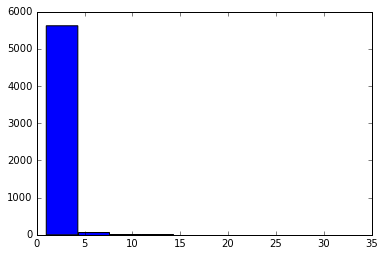

In [147]:
plt.hist(s1df.n_s12, bins=10)

(array([  5.43600000e+03,   0.00000000e+00,   1.04400000e+03,
          0.00000000e+00,   0.00000000e+00,   1.24000000e+02,
          0.00000000e+00,   7.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

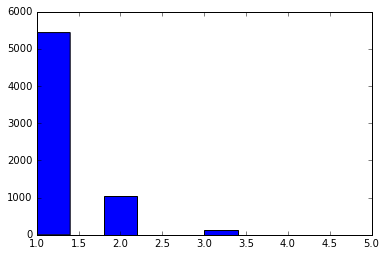

In [148]:
plt.hist(s2df.n_s12, bins=10)

(array([ 1342.,  1127.,  1249.,   777.,   398.,   220.,   158.,   103.,
           79.,    74.,    46.,    52.,    35.,    24.,    22.,    20.,
            8.,     5.,     4.,     3.]),
 array([   4.45227124,   24.32914339,   44.20601554,   64.08288769,
          83.95975984,  103.83663199,  123.71350414,  143.59037629,
         163.46724844,  183.34412059,  203.22099274,  223.09786489,
         242.97473704,  262.85160919,  282.72848134,  302.60535349,
         322.48222564,  342.35909778,  362.23596993,  382.11284208,
         401.98971423]),
 <a list of 20 Patch objects>)

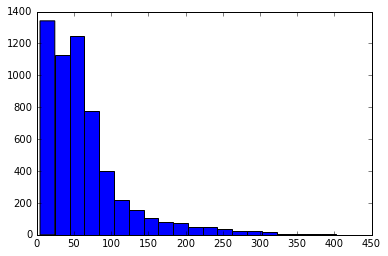

In [149]:
plt.hist(s1df.pes, bins=20)

(array([  3.54400000e+03,   2.05800000e+03,   4.89000000e+02,
          2.04000000e+02,   1.00000000e+02,   7.80000000e+01,
          4.90000000e+01,   3.40000000e+01,   1.40000000e+01,
          1.30000000e+01,   9.00000000e+00,   2.00000000e+00,
          9.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00]),
 array([  2.86974974e+02,   1.63526443e+04,   3.24183137e+04,
          4.84839830e+04,   6.45496523e+04,   8.06153217e+04,
          9.66809910e+04,   1.12746660e+05,   1.28812330e+05,
          1.44877999e+05,   1.60943668e+05,   1.77009338e+05,
          1.93075007e+05,   2.09140676e+05,   2.25206346e+05,
          2.41272015e+05,   2.57337684e+05,   2.73403354e+05,
          2.89469023e+05,   3.05534692e+05,   3.21600362e+05]),
 <a list of 20 Patch objects>)

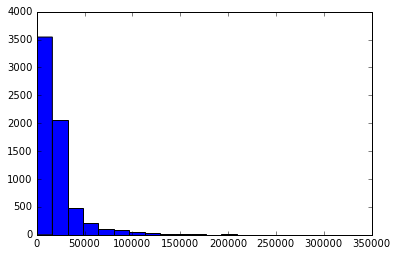

In [150]:
plt.hist(s2df.pes, bins=20)

(array([ 1350.,   831.,   788.,   723.,   586.,   501.,   335.,   231.,
          178.,   223.]),
 array([  8. ,   9.1,  10.2,  11.3,  12.4,  13.5,  14.6,  15.7,  16.8,
         17.9,  19. ]),
 <a list of 10 Patch objects>)

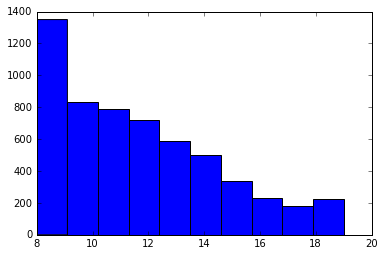

In [152]:
plt.hist(s1df.width.values, bins=10)

(array([  6.19000000e+03,   3.28000000e+02,   6.20000000e+01,
          2.50000000e+01,   3.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  100. ,  1030.5,  1961. ,  2891.5,  3822. ,  4752.5,  5683. ,
         6613.5,  7544. ,  8474.5,  9405. ]),
 <a list of 10 Patch objects>)

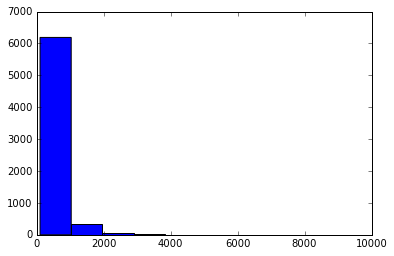

In [153]:
plt.hist(s2df.width.values)

(array([   36.,   114.,   150.,   203.,   368.,  1025.,  1969.,  1338.,
          477.,    66.]),
 array([ 0.06742749,  0.08439654,  0.10136558,  0.11833463,  0.13530367,
         0.15227272,  0.16924177,  0.18621081,  0.20317986,  0.2201489 ,
         0.23711795]),
 <a list of 10 Patch objects>)

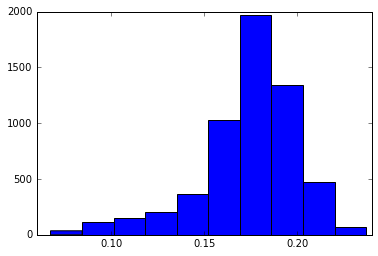

In [154]:
plt.hist(s1df.peak_to_pes)

(array([  2.57300000e+03,   2.98800000e+03,   7.17000000e+02,
          2.61000000e+02,   5.40000000e+01,   9.00000000e+00,
          5.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00]),
 array([ 0.00012665,  0.00449345,  0.00886025,  0.01322705,  0.01759385,
         0.02196065,  0.02632745,  0.03069425,  0.03506105,  0.03942785,
         0.04379465,  0.04816145,  0.05252825,  0.05689505,  0.06126185,
         0.06562865,  0.06999545,  0.07436225,  0.07872905,  0.08309585,
         0.08746266]),
 <a list of 20 Patch objects>)

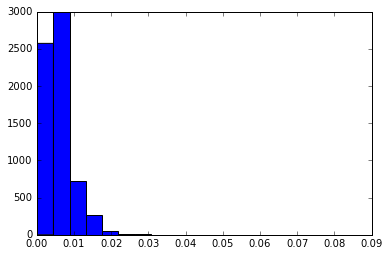

In [155]:
plt.hist(s2df.peak_to_pes, bins=20)

(array([  83.,  260.,  265.,  244.,  273.,  229.,  211.,  224.,  234.,
         260.,  211.,  274.,  252.,  241.,  268.,  282.,  268.,  343.,
         433.,  891.]),
 array([   1.15  ,   30.5925,   60.035 ,   89.4775,  118.92  ,  148.3625,
         177.805 ,  207.2475,  236.69  ,  266.1325,  295.575 ,  325.0175,
         354.46  ,  383.9025,  413.345 ,  442.7875,  472.23  ,  501.6725,
         531.115 ,  560.5575,  590.    ]),
 <a list of 20 Patch objects>)

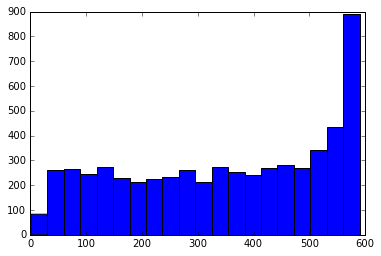

In [156]:
plt.hist(s1df.tpeak/units.mus, bins=20)

(array([ 2045.,  3255.,   524.,   252.,   113.,    96.,    47.,    49.,
           28.,    23.,    22.,    17.,    25.,    17.,    13.,    14.,
           12.,    12.,     9.,    39.]),
 array([ 592.75  ,  608.1125,  623.475 ,  638.8375,  654.2   ,  669.5625,
         684.925 ,  700.2875,  715.65  ,  731.0125,  746.375 ,  761.7375,
         777.1   ,  792.4625,  807.825 ,  823.1875,  838.55  ,  853.9125,
         869.275 ,  884.6375,  900.    ]),
 <a list of 20 Patch objects>)

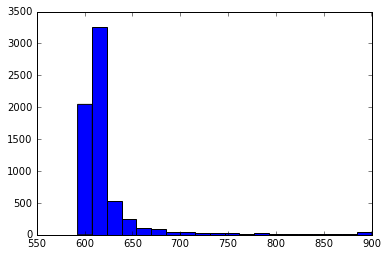

In [157]:
plt.hist(s2df.tpeak/units.mus, bins=20)

In [215]:
s12df.head()

,n_s1,n_s2,peak_s1,peak_s2,peak_to_pes_s1,peak_to_pes_s2,pes_s1,pes_s2,tpeak_s1,tpeak_s2,width_s1,width_s2
0,1,1,[29.3389360949],[145.205308681],[0.17324373899],[0.00278374442982],[169.350628576],[52161.8677079],[274750.0],[629150.0],[17],[1253]
1,1,1,[7.94937436823],[113.554181594],[0.16681652103],[0.00532557003387],[47.6533997899],[21322.4463995],[405550.0],[608675.0],[13],[450]
2,1,1,[6.4813964103],[56.5409694054],[0.180994970155],[0.00390555185074],[35.8098150724],[14477.0756006],[284125.0],[616450.0],[11],[765]
3,1,2,[6.98972217801],"[45.4465677511, 23.1268156712]",[0.176420546475],"[0.00487081603211, 0.00635718648924]",[39.6196606214],"[9330.38066958, 3637.901092]",[281075.0],"[607375.0, 621450.0]",[17],"[460, 380]"
4,1,1,[2.59174633397],[124.879611212],[0.181404918904],[0.0111643751308],[14.2870785954],[11185.5441751],[579900.0],[604175.0],[8],[205]


In [219]:
def select_ns12(s12df, n_s1=1, n_s2=1):
    s12df_ = s12df[(s12df.n_s1 == n_s1)]
    return s12df_[(s12df_.n_s2 == n_s2)]

In [240]:
def select_pes_s2(df, s2_pes_min=0, s2_pes_max=7000):
    df_ = df[df.pes_s2 > s2_pes_min]
    return df_[df_.pes_s2 < s2_pes_max]

In [220]:
def select_columns(df,column_list):
    return df.loc[:,column_list]

In [224]:
pes_s1s2_1  = select_columns(select_ns12(s12df, n_s1=1, n_s2=1),['pes_s1','pes_s2'])

In [226]:
pes_s1s2_1.head()

,pes_s1,pes_s2
0,[169.350628576],[52161.8677079]
1,[47.6533997899],[21322.4463995]
2,[35.8098150724],[14477.0756006]
4,[14.2870785954],[11185.5441751]
6,[148.763296891],[26899.3040679]


In [229]:
def get_array_from_dfc(dfc,indx=0):
    dfl = []
    for i in range(len(dfc.values)):
        dfl.append(dfc.values[i][indx])
    return np.array(dfl)



In [230]:
get_array_from_dfc(pes_s1s2_1.pes_s1,indx=0)

array([ 169.35062858,   47.65339979,   35.80981507, ...,   26.94600458,
         91.42801187,   75.71940298])

In [241]:
def data_frame_from_array(name_list, array_list):
    swf = {}
    assert(len(name_list) == len(array_list))
    
    for i, name in enumerate(name_list):
        swf[name] = array_list[i]
    return pd.DataFrame(swf)

In [242]:
pesDF = data_frame_from_array(['pes_s1','pes_s2'],
                              [get_array_from_dfc(pes_s1s2_1.pes_s1),get_array_from_dfc(pes_s1s2_1.pes_s2)])

In [243]:
pesDF.head()

,pes_s1,pes_s2
0,169.350629,52161.867708
1,47.653400,21322.446399
2,35.809815,14477.075601
3,14.287079,11185.544175
4,148.763297,26899.304068


In [244]:
krDF = select_pes_s2(pesDF, s2_pes_min=5000, s2_pes_max=7000)

In [246]:
krDF.head()

,pes_s1,pes_s2
7,10.344556,5683.908684
77,20.202620,5149.962887
94,9.641185,5900.621515
97,15.893162,6200.714249
117,13.016670,5206.257505


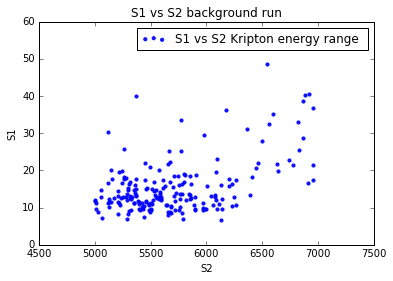

In [250]:
plt.scatter(krDF.pes_s2[krDF.pes_s1<50],krDF.pes_s1[krDF.pes_s1<50],
           # the marker as
            marker='o',
            # the color
            color='b',
            # the alpha
            alpha=0.9,
            # with size
            s = 10,
            # labelled this
            label='S1 vs S2 Kripton energy range ')
# Chart title
plt.title('S1 vs S2 background run')

# y label
plt.ylabel('S1')

# x label
plt.xlabel('S2')

# and a legend
plt.legend(loc='upper right')

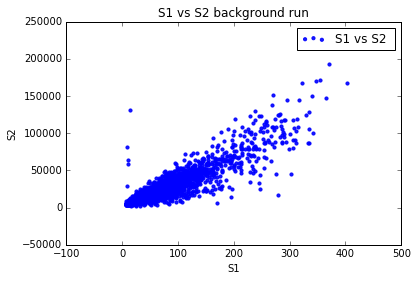

In [239]:
plt.scatter(get_array_from_dfc(pes_s1s2_1.pes_s1), get_array_from_dfc(pes_s1s2_1.pes_s2),
           # the marker as
            marker='o',
            # the color
            color='b',
            # the alpha
            alpha=0.9,
            # with size
            s = 10,
            # labelled this
            label='S1 vs S2 ')
# Chart title
plt.title('S1 vs S2 background run')

# y label
plt.ylabel('S2')

# x label
plt.xlabel('S1')

# and a legend
plt.legend(loc='upper right')